In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

Mounted at /content/drive


# BTC

In [2]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/BTC-USD.csv')
df1=df.reset_index()['Close']
df1

0         998.325012
1        1021.750000
2        1043.839966
3        1154.729980
4        1013.380005
            ...     
2347    27238.783203
2348    26345.998047
2349    26508.216797
2350    26480.375000
2351    25851.240234
Name: Close, Length: 2352, dtype: float64

In [3]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:3:1

In [4]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 [==============================] - 8s 133ms/step - loss: 0.0274 - val_loss: 0.0126
Epoch 2/100
25/25 [==============================] - 3s 114ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 3/100
25/25 [==============================] - 3s 121ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 4/100
25/25 [==============================] - 5s 206ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 5/100
25/25 [==============================] - 3s 116ms/step - loss: 9.4034e-04 - val_loss: 0.0024
Epoch 6/100
25/25 [==============================] - 3s 115ms/step - loss: 8.9228e-04 - val_loss: 0.0033
Epoch 7/100
25/25 [==============================] - 3s 118ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 8/100
25/25 [==============================] - 4s 182ms/step - loss: 9.0179e-04 - val_loss: 0.0025
Epoch 9/100
25/25 [==============================] - 3s 136ms/step - loss: 8.3451e-04 - val_loss: 0.0019
Epoch 10/100
25/25 [==============================] - 3s 118ms/step - loss:

In [10]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

5/5 [==============================] - 0s 16ms/step


In [11]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [12]:
test_data.shape

(470, 1)

In [13]:
y_pred.shape

(369, 1)

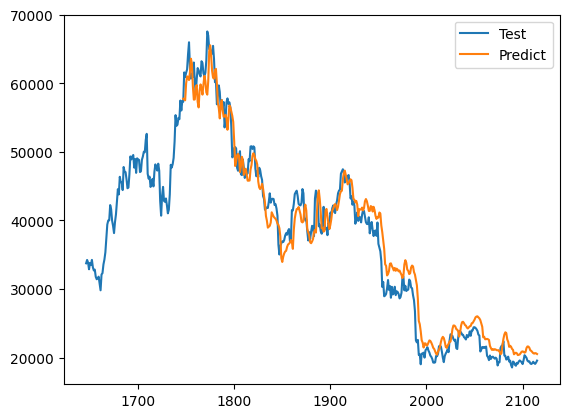

In [14]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

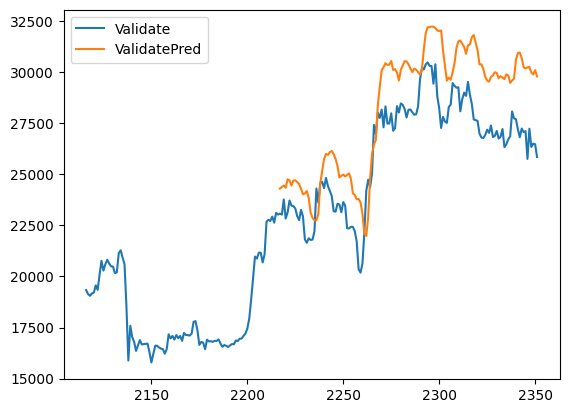

In [15]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [16]:
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('-------------------')

valid_mse = np.mean((y_pred_val - yval)**2)
test_mse = np.mean((y_pred - ytest)**2)

print('Validation MSE:', valid_mse)
print('Testing MSE:', test_mse)
print('-------------------')

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_pred_val, yval)
test_mape = mean_absolute_percentage_error(y_pred, ytest)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAE: 28225.135185143914
Testing MAE: 36973.60477143856
-------------------
Validation MSE: 805958048.8949063
Testing MSE: 1526724597.6765842
-------------------
Validation RMSE: 28389.400291216196
Testing RMSE: 39073.323350805265
-------------------
Validation MAPE: 99.99863773716807
Testing MAPE: 99.99836633886528


In [17]:
val_data.shape

(236, 1)

In [18]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[135:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

(1, 101)
[0.33984167472285126, 0.32318045918341626, 0.3230407645002817, 0.32427096670461614, 0.3241847870455838, 0.32104073551480466, 0.3135291854240855, 0.2932405577891798, 0.29060872984428837, 0.2972739822314457, 0.32020496535696785, 0.3506528208324368, 0.35886585638663354, 0.3533243317760751, 0.36345814729098547, 0.3989600727667616, 0.3921019031041932, 0.4081643644805173, 0.40410023469655343, 0.4102177037878186, 0.3972158923855853, 0.4125856997395678, 0.39999849817980515, 0.40001978721671577, 0.4075003980202764, 0.39470726596885924, 0.39662737333637377, 0.4128023332360428, 0.4080878058285503, 0.4147494028178864, 0.4137395187510307, 0.4105694407877647, 0.40444436846903153, 0.41010201775757354, 0.41025016372047074, 0.4082461869053468, 0.4064752197689368, 0.40680364995237506, 0.412571896957395, 0.43233455671060533, 0.4410497269527033, 0.43961227831349864, 0.44350533547943083, 0.44480244608548436, 0.4422989957120731, 0.4422519726745013, 0.4292212397647068, 0.44348267201293945, 0.4199028

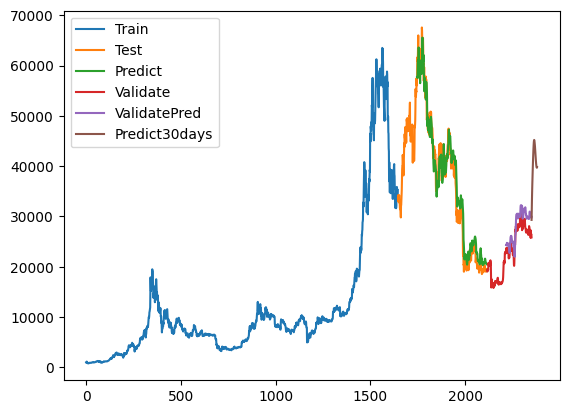

In [19]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## 5:3:2

In [20]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [21]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [22]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [23]:
# Define the model
model1 = Sequential()

# Add a 1D convolutional layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model1.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model1.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 7s 225ms/step - loss: 0.0031 - val_loss: 0.1256
Epoch 2/100
17/17 [==============================] - 2s 133ms/step - loss: 0.0011 - val_loss: 0.0405
Epoch 3/100
17/17 [==============================] - 2s 133ms/step - loss: 4.9605e-04 - val_loss: 0.0066
Epoch 4/100
17/17 [==============================] - 2s 130ms/step - loss: 2.7519e-04 - val_loss: 0.0056
Epoch 5/100
17/17 [==============================] - 3s 152ms/step - loss: 2.3117e-04 - val_loss: 0.0092
Epoch 6/100
17/17 [==============================] - 4s 237ms/step - loss: 2.0298e-04 - val_loss: 0.0147
Epoch 7/100
17/17 [==============================] - 2s 133ms/step - loss: 1.8795e-04 - val_loss: 0.0183
Epoch 8/100
17/17 [==============================] - 2s 133ms/step - loss: 1.7469e-04 - val_loss: 0.0238
Epoch 9/100
17/17 [==============================] - 2s 133ms/step - loss: 1.6037e-04 - val_loss: 0.0411
Epoch 10/100
17/17 [==============================] - 2s 133ms/

In [25]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

12/12 [==============================] - 0s 16ms/step


In [26]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

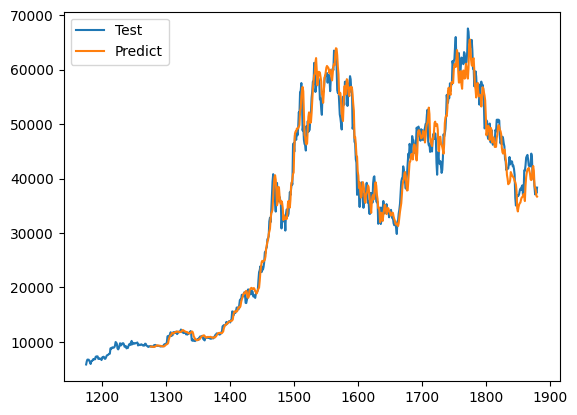

In [27]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1 + test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start = train_size1 + 101, stop = train_size1 + test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

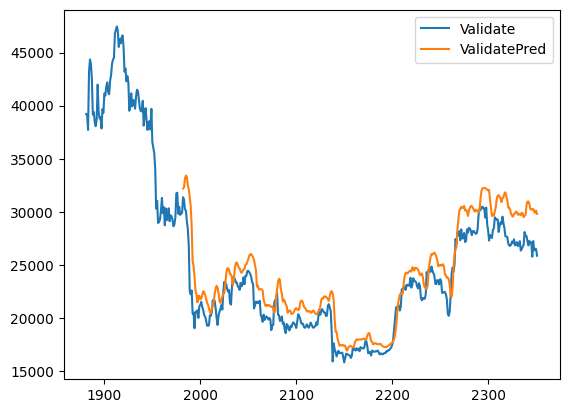

In [28]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [29]:
valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
test_mae1 = np.mean(np.abs(y_pred1 - ytest1))

print('Validation MAE:', valid_mae1)
print('Testing MAE:', test_mae1)
print('-------------------')

valid_mse1 = np.mean((y_pred_val1 - yval1)**2)
test_mse1 = np.mean((y_pred1 - ytest1)**2)

print('Validation MSE:', valid_mse1)
print('Testing MSE:', test_mse1)
print('-------------------')

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))

print('Validation RMSE:', valid_rmse1)
print('Testing RMSE:', test_rmse1)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_pred_val1, yval1)
test_mape1 = mean_absolute_percentage_error(y_pred1, ytest1)
print('Validation MAPE:', valid_mape1)
print('Testing MAPE:', test_mape1)

Validation MAE: 23934.43110233081
Testing MAE: 36508.07221350369
-------------------
Validation MSE: 593754254.1026824
Testing MSE: 1627776201.10383
-------------------
Validation RMSE: 24367.073154211244
Testing RMSE: 40345.70858348915
-------------------
Validation MAPE: 99.99860503483492
Testing MAPE: 99.99786912668374


In [30]:
val_data1.shape

(471, 1)

In [31]:
# 13. Dự báo 30 ngày tiếp theo
x_input1=val_data1[370:].reshape(1,-1)
print(x_input1.shape)

temp_input1=list(x_input1)
temp_input1=temp_input1[0].tolist()
print(temp_input1)
from numpy import array

lst_output1=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input1)>100):
        x_input1 = np.array(temp_input1[1:])
        print("{} day input {}".format(i,x_input1))
        x_input1 = x_input1.reshape(1,-1)
        x_input1 = x_input1.reshape((1, n_steps, 1))

        yhat1 = model.predict(x_input1, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input1.extend(yhat1[0].tolist())
        temp_input1 = temp_input1[1:]

        lst_output1.extend(yhat1.tolist())
        i=i+1
    else:
        x_input1 = x_input1.reshape((1, n_steps,1))
        yhat1 = model1.predict(x_input1, verbose=0)
        print(yhat1[0])
        temp_input1.extend1(yhat1[0].tolist())
        print(len(temp_input1))
        lst_output1.extend(yhat1.tolist())
        i=i+1

(1, 101)
[0.33984167472285126, 0.32318045918341626, 0.3230407645002817, 0.32427096670461614, 0.3241847870455838, 0.32104073551480466, 0.3135291854240855, 0.2932405577891798, 0.29060872984428837, 0.2972739822314457, 0.32020496535696785, 0.3506528208324368, 0.35886585638663354, 0.3533243317760751, 0.36345814729098547, 0.3989600727667616, 0.3921019031041932, 0.4081643644805173, 0.40410023469655343, 0.4102177037878186, 0.3972158923855853, 0.4125856997395678, 0.39999849817980515, 0.40001978721671577, 0.4075003980202764, 0.39470726596885924, 0.39662737333637377, 0.4128023332360428, 0.4080878058285503, 0.4147494028178864, 0.4137395187510307, 0.4105694407877647, 0.40444436846903153, 0.41010201775757354, 0.41025016372047074, 0.4082461869053468, 0.4064752197689368, 0.40680364995237506, 0.412571896957395, 0.43233455671060533, 0.4410497269527033, 0.43961227831349864, 0.44350533547943083, 0.44480244608548436, 0.4422989957120731, 0.4422519726745013, 0.4292212397647068, 0.44348267201293945, 0.4199028

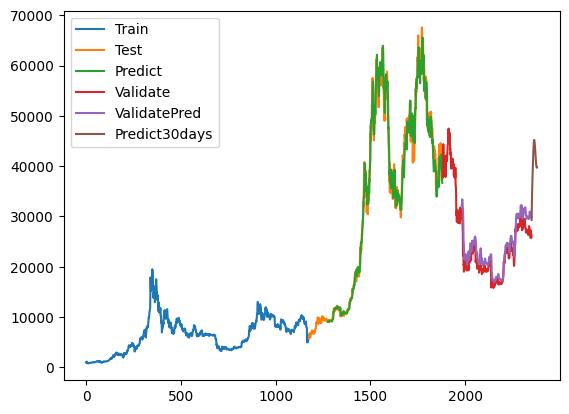

In [32]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

prediect_data_index1 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index1,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# DOGE

In [99]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv')
df1=df.reset_index()['Close']
df1

0       0.001415
1       0.001163
2       0.001201
3       0.001038
4       0.001211
          ...   
2035    0.070373
2036    0.067300
2037    0.067966
2038    0.069489
2039    0.061860
Name: Close, Length: 2040, dtype: float64

In [100]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:3:1

In [101]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [102]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [103]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [104]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [105]:
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [106]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 7s 138ms/step - loss: 0.0121 - val_loss: 0.0010
Epoch 2/100
21/21 [==============================] - 3s 120ms/step - loss: 0.0035 - val_loss: 5.0255e-04
Epoch 3/100
21/21 [==============================] - 2s 119ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 4/100
21/21 [==============================] - 5s 222ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 5/100
21/21 [==============================] - 3s 122ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 6/100
21/21 [==============================] - 3s 125ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
21/21 [==============================] - 2s 119ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/100
21/21 [==============================] - 3s 144ms/step - loss: 0.0011 - val_loss: 5.2208e-04
Epoch 9/100
21/21 [==============================] - 4s 203ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 10/100
21/21 [==============================] - 3s 122ms/step - loss: 0.0011 

In [107]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 24ms/step


In [108]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [109]:
test_data.shape

(408, 1)

In [110]:
y_pred.shape

(307, 1)

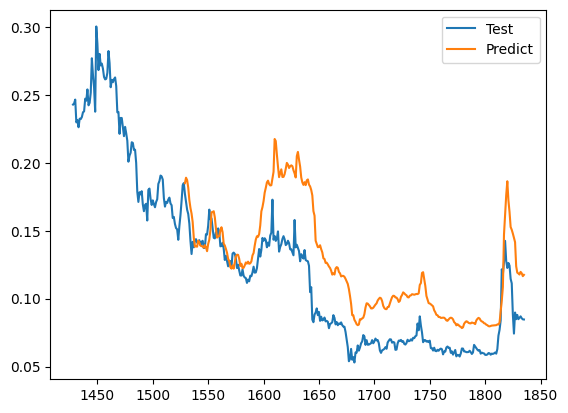

In [111]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

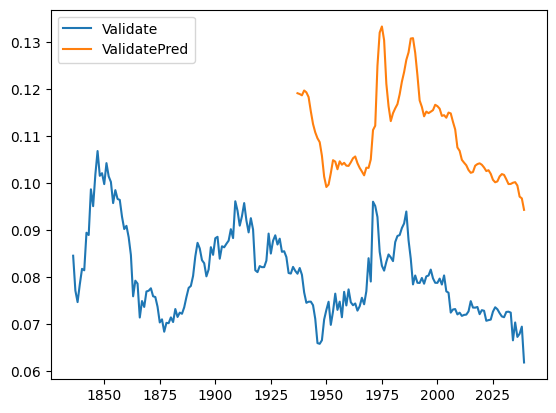

In [112]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [113]:
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('-------------------')

valid_mse = np.mean((y_pred_val - yval)**2)
test_mse = np.mean((y_pred - ytest)**2)

print('Validation MSE:', valid_mse)
print('Testing MSE:', test_mse)
print('-------------------')

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_pred_val, yval)
test_mape = mean_absolute_percentage_error(y_pred, ytest)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAE: 0.010339051853436577
Testing MAE: 0.051842933857678464
-------------------
Validation MSE: 0.0001748189190343228
Testing MSE: 0.004268836513537803
-------------------
Validation RMSE: 0.013221910566719274
Testing RMSE: 0.06533633379321037
-------------------
Validation MAPE: 9.338591231483374
Testing MAPE: 45.09531872837469


In [114]:
val_data.shape

(204, 1)

In [115]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[103:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

(1, 101)
[0.11624610283428666, 0.1107718023180106, 0.10752348226430411, 0.10787303043531762, 0.10788765396688135, 0.10678050443076667, 0.10251279782396615, 0.09499091957146999, 0.09476569321238641, 0.09587868344367119, 0.10232413029379199, 0.10530772301828205, 0.10786132725133893, 0.10066414152492571, 0.10483532410595031, 0.1103798328292792, 0.10532088637605326, 0.10789935715086008, 0.10303492981979773, 0.11094291507221679, 0.10670884694674065, 0.11170051643731797, 0.10770483802869649, 0.10677465283877724, 0.10732019120256622, 0.10509418894635798, 0.10645143138330616, 0.10908986735497947, 0.10706862723112098, 0.11114913737835908, 0.12141035614968203, 0.11415320522640217, 0.1390018652957422, 0.13765632604277273, 0.13423104164287078, 0.12340088903662065, 0.11907759775433117, 0.11754045972678313, 0.12029736591839726, 0.12258186230086028, 0.1216823952446804, 0.12050650857212457, 0.12643128360020617, 0.128334053504124, 0.12861047312049975, 0.1308013658247719, 0.13223027664256531, 0.13594514

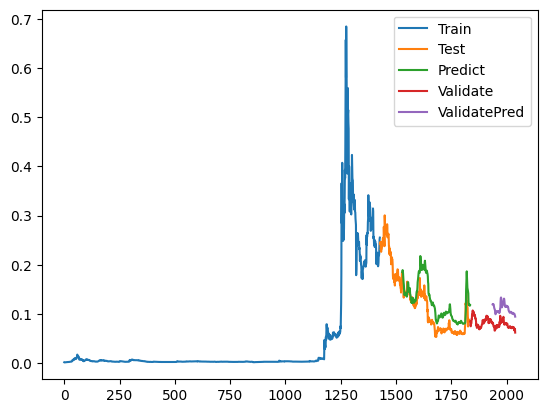

In [116]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [117]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [118]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [119]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [120]:
# Define the model
model1 = Sequential()

# Add a 1D convolutional layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model1.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model1.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 5s 155ms/step - loss: 6.4669e-06 - val_loss: 0.0907
Epoch 2/100
15/15 [==============================] - 2s 127ms/step - loss: 2.6990e-06 - val_loss: 0.0899
Epoch 3/100
15/15 [==============================] - 2s 163ms/step - loss: 2.5586e-06 - val_loss: 0.0902
Epoch 4/100
15/15 [==============================] - 4s 235ms/step - loss: 2.4895e-06 - val_loss: 0.0897
Epoch 5/100
15/15 [==============================] - 2s 129ms/step - loss: 2.4488e-06 - val_loss: 0.0899
Epoch 6/100
15/15 [==============================] - 2s 127ms/step - loss: 2.4694e-06 - val_loss: 0.0895
Epoch 7/100
15/15 [==============================] - 2s 128ms/step - loss: 2.6226e-06 - val_loss: 0.0892
Epoch 8/100
15/15 [==============================] - 2s 130ms/step - loss: 2.3920e-06 - val_loss: 0.0889
Epoch 9/100
15/15 [==============================] - 2s 133ms/step - loss: 2.4086e-06 - val_loss: 0.0888
Epoch 10/100
15/15 [==============================] - 4

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
test_mae1 = np.mean(np.abs(y_pred1 - ytest1))

print('Validation MAE:', valid_mae1)
print('Testing MAE:', test_mae1)
print('-------------------')

valid_mse1 = np.mean((y_pred_val1 - yval1)**2)
test_mse1 = np.mean((y_pred1 - ytest1)**2)

print('Validation MSE:', valid_mse1)
print('Testing MSE:', test_mse1)
print('-------------------')

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))

print('Validation RMSE:', valid_rmse1)
print('Testing RMSE:', test_rmse1)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_pred_val1, yval1)
test_mape1 = mean_absolute_percentage_error(y_pred1, ytest1)
print('Validation MAPE:', valid_mape1)
print('Testing MAPE:', test_mape1)

In [ ]:
val_data1.shape

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input1=val_data1[307:].reshape(1,-1)
print(x_input1.shape)

temp_input1=list(x_input1)
temp_input1=temp_input1[0].tolist()
print(temp_input1)
from numpy import array

lst_output1=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input1)>100):
        x_input1 = np.array(temp_input1[1:])
        print("{} day input {}".format(i,x_input1))
        x_input1 = x_input1.reshape(1,-1)
        x_input1 = x_input1.reshape((1, n_steps, 1))

        yhat1 = model.predict(x_input1, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input1.extend(yhat1[0].tolist())
        temp_input1 = temp_input1[1:]

        lst_output1.extend(yhat1.tolist())
        i=i+1
    else:
        x_input1 = x_input1.reshape((1, n_steps,1))
        yhat1 = model1.predict(x_input1, verbose=0)
        print(yhat1[0])
        temp_input1.extend1(yhat1[0].tolist())
        print(len(temp_input1))
        lst_output1.extend(yhat1.tolist())
        i=i+1

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

# prediect_data_index1 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index1,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# ETH

In [64]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv')
df1=df.reset_index()['Close']
df1

0       0.001415
1       0.001163
2       0.001201
3       0.001038
4       0.001211
          ...   
2035    0.070373
2036    0.067300
2037    0.067966
2038    0.069489
2039    0.061860
Name: Close, Length: 2040, dtype: float64

In [65]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:3:1

In [66]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [67]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [68]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [69]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [70]:
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [71]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 8s 246ms/step - loss: 0.0097 - val_loss: 0.0013
Epoch 2/100
21/21 [==============================] - 2s 119ms/step - loss: 0.0036 - val_loss: 0.0010
Epoch 3/100
21/21 [==============================] - 3s 120ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 4/100
21/21 [==============================] - 3s 120ms/step - loss: 0.0018 - val_loss: 5.7270e-04
Epoch 5/100
21/21 [==============================] - 3s 168ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/100
21/21 [==============================] - 4s 175ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/100
21/21 [==============================] - 2s 118ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 8/100
21/21 [==============================] - 2s 119ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/100
21/21 [==============================] - 2s 120ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 10/100
21/21 [==============================] - 4s 180ms/step - loss: 0.0015 - va

In [72]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 15ms/step


In [73]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [74]:
test_data.shape

(408, 1)

In [75]:
y_pred.shape

(307, 1)

In [77]:
val_data.shape

(204, 1)

In [78]:
y_pred_val.shape

(103, 1)

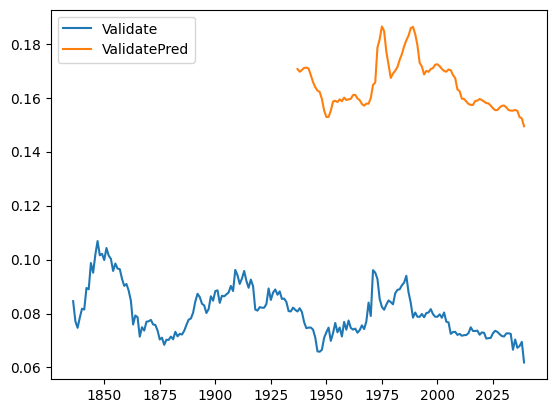

In [79]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,(y_pred_val))

plt.legend(['Validate','ValidatePred'])
plt.show()

In [80]:
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('-------------------')

valid_mse = np.mean((y_pred_val - yval)**2)
test_mse = np.mean((y_pred - ytest)**2)

print('Validation MSE:', valid_mse)
print('Testing MSE:', test_mse)
print('-------------------')

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_pred_val, yval)
test_mape = mean_absolute_percentage_error(y_pred, ytest)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAE: 0.05384846307571632
Testing MAE: 0.0536598173565594
-------------------
Validation MSE: 0.00306891779284246
Testing MSE: 0.004057983719581067
-------------------
Validation RMSE: 0.05539781397169441
Testing RMSE: 0.06370230544949741
-------------------
Validation MAPE: 32.49823263845186
Testing MAPE: 36.97032842141539


In [81]:
val_data.shape

(204, 1)

In [82]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[103:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

(1, 101)
[0.11624610283428666, 0.1107718023180106, 0.10752348226430411, 0.10787303043531762, 0.10788765396688135, 0.10678050443076667, 0.10251279782396615, 0.09499091957146999, 0.09476569321238641, 0.09587868344367119, 0.10232413029379199, 0.10530772301828205, 0.10786132725133893, 0.10066414152492571, 0.10483532410595031, 0.1103798328292792, 0.10532088637605326, 0.10789935715086008, 0.10303492981979773, 0.11094291507221679, 0.10670884694674065, 0.11170051643731797, 0.10770483802869649, 0.10677465283877724, 0.10732019120256622, 0.10509418894635798, 0.10645143138330616, 0.10908986735497947, 0.10706862723112098, 0.11114913737835908, 0.12141035614968203, 0.11415320522640217, 0.1390018652957422, 0.13765632604277273, 0.13423104164287078, 0.12340088903662065, 0.11907759775433117, 0.11754045972678313, 0.12029736591839726, 0.12258186230086028, 0.1216823952446804, 0.12050650857212457, 0.12643128360020617, 0.128334053504124, 0.12861047312049975, 0.1308013658247719, 0.13223027664256531, 0.13594514

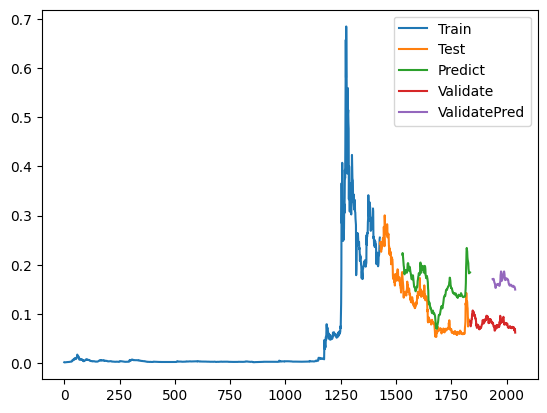

In [98]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [84]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [85]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [86]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [87]:
# Define the model
model1 = Sequential()

# Add a 1D convolutional layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model1.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model1.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [88]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 6s 155ms/step - loss: 5.5394e-06 - val_loss: 0.0927
Epoch 2/100
15/15 [==============================] - 2s 131ms/step - loss: 2.6580e-06 - val_loss: 0.0925
Epoch 3/100
15/15 [==============================] - 2s 126ms/step - loss: 2.3751e-06 - val_loss: 0.0924
Epoch 4/100
15/15 [==============================] - 2s 128ms/step - loss: 2.4097e-06 - val_loss: 0.0922
Epoch 5/100
15/15 [==============================] - 4s 255ms/step - loss: 2.4920e-06 - val_loss: 0.0920
Epoch 6/100
15/15 [==============================] - 2s 147ms/step - loss: 2.3434e-06 - val_loss: 0.0921
Epoch 7/100
15/15 [==============================] - 2s 128ms/step - loss: 2.3928e-06 - val_loss: 0.0923
Epoch 8/100
15/15 [==============================] - 2s 132ms/step - loss: 2.4219e-06 - val_loss: 0.0921
Epoch 9/100
15/15 [==============================] - 2s 127ms/step - loss: 2.4123e-06 - val_loss: 0.0919
Epoch 10/100
15/15 [==============================] - 2

In [89]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 16ms/step


In [90]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

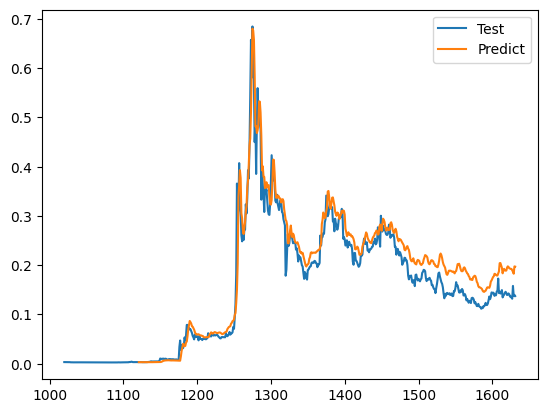

In [91]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

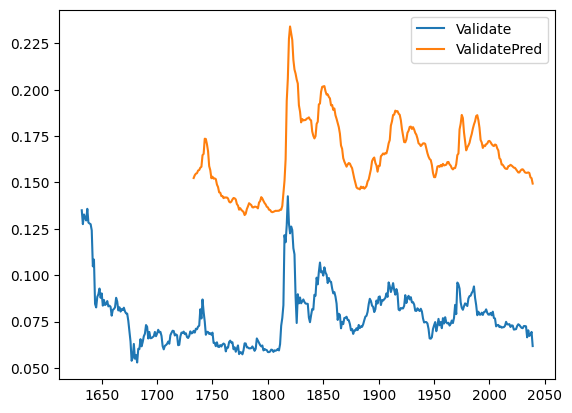

In [92]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [93]:
valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
test_mae1 = np.mean(np.abs(y_pred1 - ytest1))

print('Validation MAE:', valid_mae1)
print('Testing MAE:', test_mae1)
print('-------------------')

valid_mse1 = np.mean((y_pred_val1 - yval1)**2)
test_mse1 = np.mean((y_pred1 - ytest1)**2)

print('Validation MSE:', valid_mse1)
print('Testing MSE:', test_mse1)
print('-------------------')

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))

print('Validation RMSE:', valid_rmse1)
print('Testing RMSE:', test_rmse1)
print('-------------------')

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_pred_val1, yval1)
test_mape1 = mean_absolute_percentage_error(y_pred1, ytest1)
print('Validation MAPE:', valid_mape1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.052933848351148956
Testing MAE: 0.17051234458775957
-------------------
Validation MSE: 0.0034429431182091933
Testing MSE: 0.048361273708268065
-------------------
Validation RMSE: 0.05867659770478511
Testing RMSE: 0.21991196808784205
-------------------
Validation MAPE: 31.443186923828335
Testing MAPE: 797.4044521297703


In [94]:
val_data1.shape

(408, 1)

In [95]:
# 13. Dự báo 30 ngày tiếp theo
x_input1=val_data1[307:].reshape(1,-1)
print(x_input1.shape)

temp_input1=list(x_input1)
temp_input1=temp_input1[0].tolist()
print(temp_input1)
from numpy import array

lst_output1=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input1)>100):
        x_input1 = np.array(temp_input1[1:])
        print("{} day input {}".format(i,x_input1))
        x_input1 = x_input1.reshape(1,-1)
        x_input1 = x_input1.reshape((1, n_steps, 1))

        yhat1 = model.predict(x_input1, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input1.extend(yhat1[0].tolist())
        temp_input1 = temp_input1[1:]

        lst_output1.extend(yhat1.tolist())
        i=i+1
    else:
        x_input1 = x_input1.reshape((1, n_steps,1))
        yhat1 = model1.predict(x_input1, verbose=0)
        print(yhat1[0])
        temp_input1.extend1(yhat1[0].tolist())
        print(len(temp_input1))
        lst_output1.extend(yhat1.tolist())
        i=i+1

(1, 101)
[0.11624610283428666, 0.1107718023180106, 0.10752348226430411, 0.10787303043531762, 0.10788765396688135, 0.10678050443076667, 0.10251279782396615, 0.09499091957146999, 0.09476569321238641, 0.09587868344367119, 0.10232413029379199, 0.10530772301828205, 0.10786132725133893, 0.10066414152492571, 0.10483532410595031, 0.1103798328292792, 0.10532088637605326, 0.10789935715086008, 0.10303492981979773, 0.11094291507221679, 0.10670884694674065, 0.11170051643731797, 0.10770483802869649, 0.10677465283877724, 0.10732019120256622, 0.10509418894635798, 0.10645143138330616, 0.10908986735497947, 0.10706862723112098, 0.11114913737835908, 0.12141035614968203, 0.11415320522640217, 0.1390018652957422, 0.13765632604277273, 0.13423104164287078, 0.12340088903662065, 0.11907759775433117, 0.11754045972678313, 0.12029736591839726, 0.12258186230086028, 0.1216823952446804, 0.12050650857212457, 0.12643128360020617, 0.128334053504124, 0.12861047312049975, 0.1308013658247719, 0.13223027664256531, 0.13594514

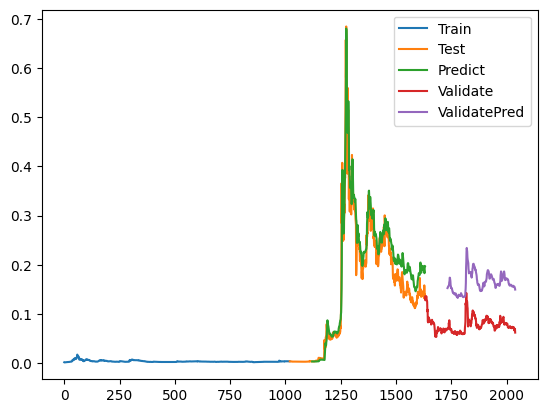

In [97]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

# prediect_data_index1 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index1,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()